# NLP-Driven Sentiment Analysis from Scraped Articles
## Objective
The objective of this project is to perform sentiment analysis by first creating a custom dataset through web scraping. This involves extracting articles from targeted websites. The collected data is then cleaned, preprocessed, and analyzed using natural language processing (NLP) techniques to identify and classify sentiments (positive, negative, or neutral). The project aims to uncover insights into public opinion and trends by automating the end-to-end process from data collection to sentiment classification.
#### Step 1: Initial Setup – Importing Required Python Packages


In [33]:
# Import libraries
!pip install wordcloud

from bs4 import BeautifulSoup,SoupStrainer
import requests
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder

import warnings 
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Step 2: Before we jump into scraping the actual content, let’s first import our dataset containing the article links.

In [3]:
# Import dataset with links
df = pd.read_excel(r"D:\My work\Input.xlsx")
urls = df['URL']
print("Total number of article links available for scraping:", len(urls))

# Preview the first 5 links to get an idea of the dataset
urls.head()

Total number of article links available for scraping: 114


0    https://insights.blackcoffer.com/rise-of-telem...
1    https://insights.blackcoffer.com/rise-of-e-hea...
2    https://insights.blackcoffer.com/rise-of-e-hea...
3    https://insights.blackcoffer.com/rise-of-telem...
4    https://insights.blackcoffer.com/rise-of-telem...
Name: URL, dtype: object

#### Step 3: Now That We Have the URLs, Let’s Begin Scraping the Content!

In [4]:
Tittle = []
Text = []
url = []

for i in urls:
    page = requests.get(i)
    soup = BeautifulSoup(page.content)
    # Check if the element exists on the page before appending to the lists
    title_element = soup.find("h1", class_="entry-title")
    if title_element:
        Tittle.append(title_element.text)
        url.append(i)
    
    text_element = soup.find("div", class_="td-post-content tagdiv-type")
    if text_element:
        Text.append(text_element.text)

# Create a DataFrame after collecting data
df1 = pd.DataFrame({'URL':url,'Tittle': Tittle, 'Text': Text})

#### Let's preview the first five rows of the dataset, and also check for any null values and duplicates. 

In [7]:
# Preview the first five rows of the dataset
df1.head()

,URL,Tittle,Text
0,https://insights.blackcoffer.com/rise-of-telem...,Rise of telemedicine and its Impact on Livelih...,"\nTelemedicine, the use of technology to diagn..."
1,https://insights.blackcoffer.com/rise-of-e-hea...,Rise of e-health and its impact on humans by t...,"\nThe rise of e-health, or the use of electron..."
2,https://insights.blackcoffer.com/rise-of-telem...,Rise of telemedicine and its Impact on Livelih...,"\n“More gains on quality, affordability and ac..."
3,https://insights.blackcoffer.com/rise-of-telem...,Rise of telemedicine and its Impact on Livelih...,"\n“More gains on quality, affordability and ac..."
4,https://insights.blackcoffer.com/rise-of-chatb...,Rise of Chatbots and its impact on customer su...,\nThe human race is known to come up with inve...


In [8]:
print("Null values in the dataset:")
print(df1.isnull().sum())

print("\nDuplicate rows in the dataset:")
print(df1.duplicated().sum())

Null values in the dataset:
URL       0
Tittle    0
Text      0
dtype: int64

Duplicate rows in the dataset:
0


#### Perfect!

#### Step 4: Feature Extraction – Unveiling Insights from Text!
Now that we've scraped the articles, it's time to delve deeper into the text and extract meaningful features. We’ll use NLTK and TextBlob to capture various attributes like sentiment scores, sentence length, word complexity, and more. These features will allow us to better understand the structure and sentiment of the articles, bringing us closer to our final analysis.

Let’s begin extracting these linguistic features to prepare our dataset for machine learning or further analysis!

In [12]:
# Apply various text analysis metrics to the dataset
df1['No of character'] = df1['Text'].apply(len)
df1['No of word'] = df1['Text'].apply(lambda x: len(nltk.word_tokenize(x)))
df1['No of sentences'] = df1['Text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Load positive and negative word lists
with open('positive-words.txt', 'r') as positive_file:
    positive_words = set(positive_file.read().split())

with open('negative-words.txt', 'r') as negative_file:
    negative_words = set(negative_file.read().split())

# Calculate Positive Score
df1['Positive Score'] = df1['Text'].apply(lambda x: len([word for word in nltk.word_tokenize(x) if word in positive_words]))

# Calculate Negative Score
df1['Negative Score'] = df1['Text'].apply(lambda x: len([word for word in nltk.word_tokenize(x) if word in negative_words]))

# Calculate Polarity Score using TextBlob
df1['Polarity Score'] = df1['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Calculate Subjectivity Score using TextBlob
df1['Subjectivity Score'] = df1['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Calculate Average Sentence Length
df1['Avg Sentence Length'] = df1['No of character'] / df1['No of sentences']

# Calculate Percentage of Complex Words
def is_complex_word(word):
    return len(word) > 6  # You can adjust the threshold for complexity

df1['Percentage of Complex Words'] = df1['Text'].apply(lambda x: sum(1 for word in nltk.word_tokenize(x) if is_complex_word(word)) / len(nltk.word_tokenize(x)))

# Calculate Fog Index
df1['Fog Index'] = 0.4 * (df1['Avg Sentence Length'] + df1['Percentage of Complex Words'])

# Calculate Average Number of Words per Sentence
df1['Avg Number of Words per Sentence'] = df1['No of word'] / df1['No of sentences']

# Calculate Complex Word Count
df1['Complex Word Count'] = df1['Text'].apply(lambda x: sum(1 for word in nltk.word_tokenize(x) if is_complex_word(word)))

# Calculate Word Count
df1['Word Count'] = df1['Text'].apply(lambda x: len(nltk.word_tokenize(x)))

# Calculate Syllables per Word
def count_syllables(word):
    # Simple heuristic to count syllables
    vowels = "AEIOUaeiou"
    count = 0
    for char in word:
        if char in vowels:
            count += 1
    return count

df1['Syllables per Word'] = df1['Text'].apply(lambda x: sum(count_syllables(word) for word in nltk.word_tokenize(x)) / len(nltk.word_tokenize(x)))

# Calculate Personal Pronouns
personal_pronouns = set(['I', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves'])
df1['Personal Pronouns'] = df1['Text'].apply(lambda x: len([word for word in nltk.word_tokenize(x) if word.lower() in personal_pronouns]))

# Calculate Average Word Length
df1['Avg Word Length'] = df1.apply(lambda row: row['No of character'] / row['Word Count'], axis=1)


In [14]:
# Preview the first 2 rows of the dataset now.
df1.head(2)

,URL,Tittle,Text,No of character,No of word,No of sentences,Positive Score,Negative Score,Polarity Score,Subjectivity Score,Avg Sentence Length,Percentage of Complex Words,Fog Index,Avg Number of Words per Sentence,Complex Word Count,Syllables per Word,Personal Pronouns,Word Count,Avg Word Length
0,https://insights.blackcoffer.com/rise-of-telem...,Rise of telemedicine and its Impact on Livelih...,"\nTelemedicine, the use of technology to diagn...",11146,1797,56,82,22,0.132210,0.438632,199.035714,0.324430,79.744058,32.089286,583,2.061213,45,1797,6.202560
1,https://insights.blackcoffer.com/rise-of-e-hea...,Rise of e-health and its impact on humans by t...,"\nThe rise of e-health, or the use of electron...",4007,652,19,41,13,0.111801,0.615704,210.894737,0.342025,84.494705,34.315789,223,2.023006,18,652,6.145706


The dataset consists of various articles, accompanied by textual, sentiment, and readability metrics. Here's a breakdown of what the columns represent and how they contribute to the analysis:

- **URL** and **Title** identify each article.
- **Text**, **No of character**, **No of word**, and **No of sentences** provide structural metrics of the content.
- **Positive Score**, **Negative Score**, **Polarity Score**, and **Subjectivity Score** capture sentiment and emotional tone.
- **Avg Sentence Length**, **Percentage of Complex Words**, and **Fog Index** measure the readability level.
- **Complex Word Count**, **Syllables per Word**, and **Avg Word Length** offer insights into linguistic complexity.
- **Personal Pronouns** detects personal or subjective language use.


#### Step 5: Exploratory Data Analysis through Visualizations
In this step, we analyze the dataset using a series of visualizations to uncover insights related to sentiment, readability, and linguistic complexity. Each set of plots highlights a specific dimension of the data—ranging from emotional tone and objectivity, to structural elements like sentence length, word complexity, and personal language use. The goal is to identify trends, variations, and potential correlations within the textual features across articles.



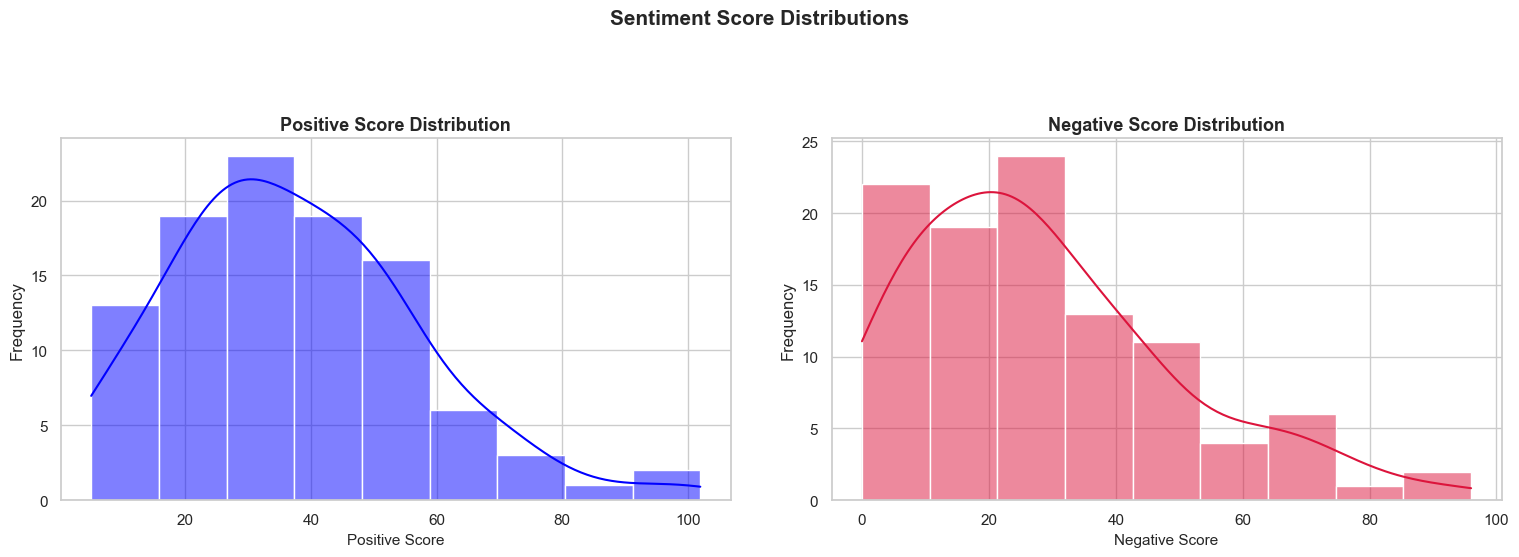

In [18]:
# Distribution of Positive and Negative Sentiment in the Articles
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive Score
sns.histplot(data=df1, x='Positive Score', kde=True, color='blue', ax=axes[0])
axes[0].set_title('Positive Score Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Positive Score', fontsize=11)
axes[0].set_ylabel('Frequency')

# Negative Score
sns.histplot(data=df1, x='Negative Score', kde=True, color='crimson', ax=axes[1])
axes[1].set_title('Negative Score Distribution', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Negative Score', fontsize=11)
axes[1].set_ylabel('Frequency')

# Overall Title
plt.suptitle('Sentiment Score Distributions', fontsize=15, fontweight='bold')
plt.tight_layout(pad=3)
plt.show()


- **Positive Score**: Most responses have positive scores clustered between **20 and 50**, showing a generally optimistic sentiment with a peak around **30–35**.
- **Negative Score**: Negative scores are skewed left, with a peak around **10–20**, and fewer high negative scores, indicating that **strongly negative sentiments are rare**.
- Overall, **positive sentiment dominates**, suggesting a **favorable or constructive tone** in the data.

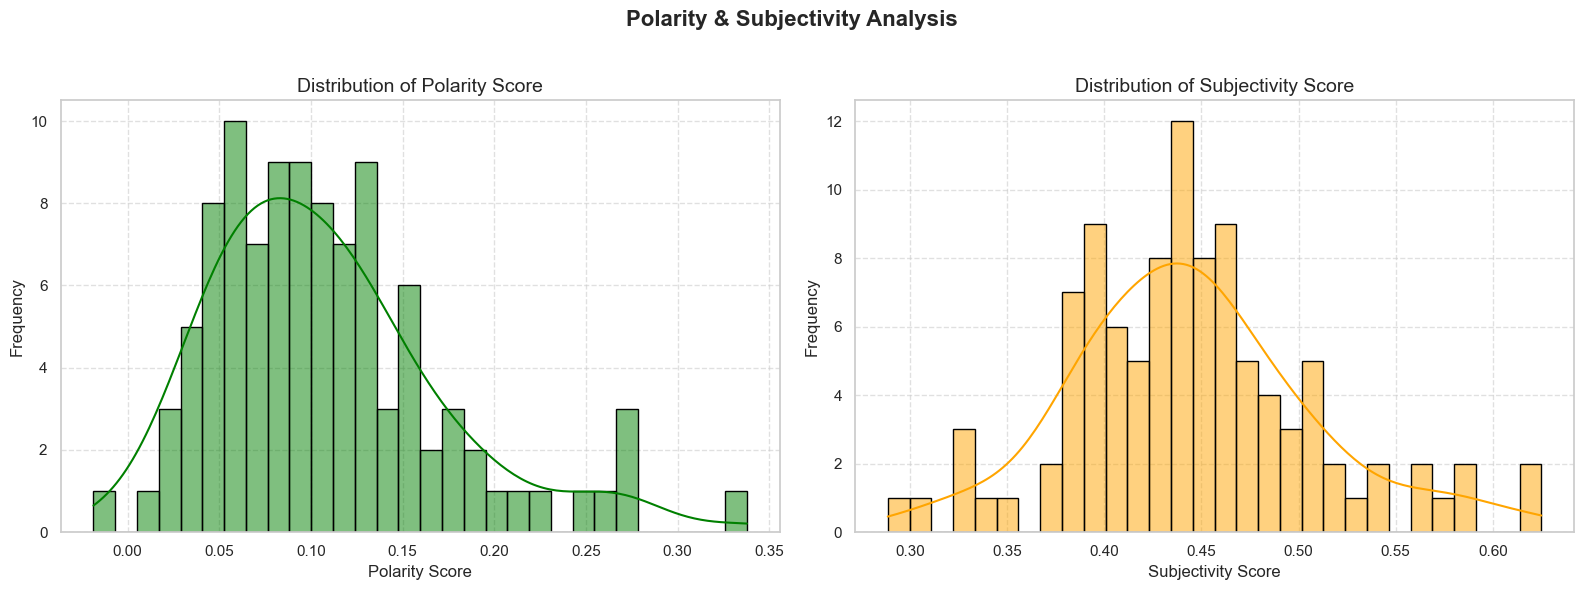

In [19]:
# Measure of overall emotional tone and objectivity in the articles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Polarity Score plot with enhancements
sns.histplot(data=df1, x='Polarity Score', kde=True, color='green', ax=axes[0], bins=30, edgecolor='black')
axes[0].set_title('Distribution of Polarity Score', fontsize=14)
axes[0].set_xlabel('Polarity Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Subjectivity Score plot with enhancements
sns.histplot(data=df1, x='Subjectivity Score', kde=True, color='orange', ax=axes[1], bins=30, edgecolor='black')
axes[1].set_title('Distribution of Subjectivity Score', fontsize=14)
axes[1].set_xlabel('Subjectivity Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Title for the whole figure
plt.suptitle('Polarity & Subjectivity Analysis', fontsize=16, fontweight='bold')

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


- **Polarity:** Most responses show a slightly positive sentiment, clustered around 0.05-0.15 with a peak around 0.08-0.10. There's a slight positive skew, meaning strong positive sentiment is less frequent. 
- **Subjectivity:** Subjectivity scores are centered around 0.42-0.48, indicating many responses contain opinions or personal viewpoints. There's a wide spread in subjectivity levels. 
- **Overall:** The data leans towards a mildly positive sentiment, and a significant portion of responses expresses subjective content and opinions.

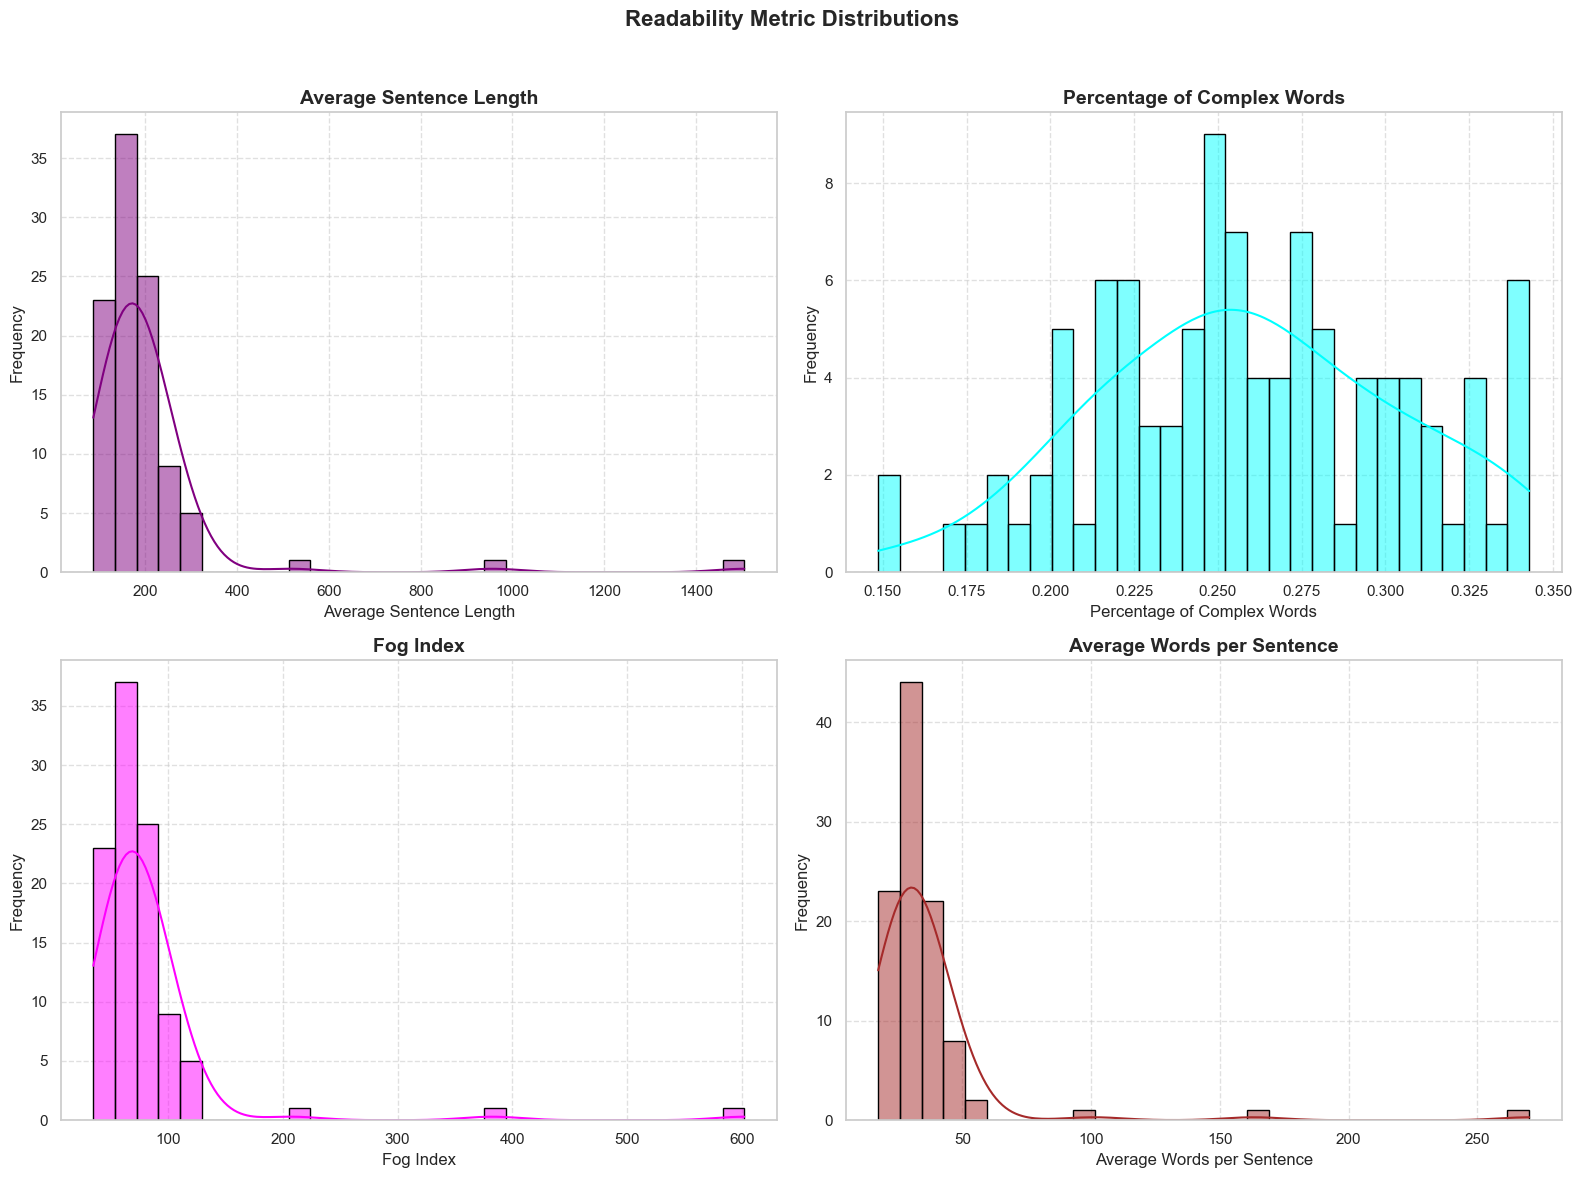

In [21]:
# Key metrics to assess clarity and ease of reading
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Average Sentence Length plot with enhancements
sns.histplot(data=df1, x='Avg Sentence Length', kde=True, color='purple', ax=axes[0, 0], bins=30, edgecolor='black')
axes[0, 0].set_title('Average Sentence Length', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Average Sentence Length', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# Percentage of Complex Words plot with enhancements
sns.histplot(data=df1, x='Percentage of Complex Words', kde=True, color='cyan', ax=axes[0, 1], bins=30, edgecolor='black')
axes[0, 1].set_title('Percentage of Complex Words', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Percentage of Complex Words', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# Fog Index plot with enhancements
sns.histplot(data=df1, x='Fog Index', kde=True, color='magenta', ax=axes[1, 0], bins=30, edgecolor='black')
axes[1, 0].set_title('Fog Index', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Fog Index', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].grid(True, linestyle='--', alpha=0.6)

# Average Number of Words per Sentence plot with enhancements
sns.histplot(data=df1, x='Avg Number of Words per Sentence', kde=True, color='brown', ax=axes[1, 1], bins=30, edgecolor='black')
axes[1, 1].set_title('Average Words per Sentence', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Words per Sentence', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].grid(True, linestyle='--', alpha=0.6)

# Title for the whole figure
plt.suptitle('Readability Metric Distributions', fontsize=16, fontweight='bold')

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


- **Average Sentence Length & Words per Sentence:** Most responses have short sentences (peaking below 100 and 50 respectively), with fewer instances of longer sentences.
- **Percentage of Complex Words:** The use of complex words varies considerably across responses, with no strong central tendency.
- **Fog Index:** Most text has a low Fog Index (peaking below 100), indicating easier readability. Higher Fog Index scores, suggesting more difficult text, are less common.
- **Overall:** The majority of the text is characterized by short sentences and easier readability. The use of complex words is the most variable metric. While most text is simple, some longer and potentially more complex sections exist.

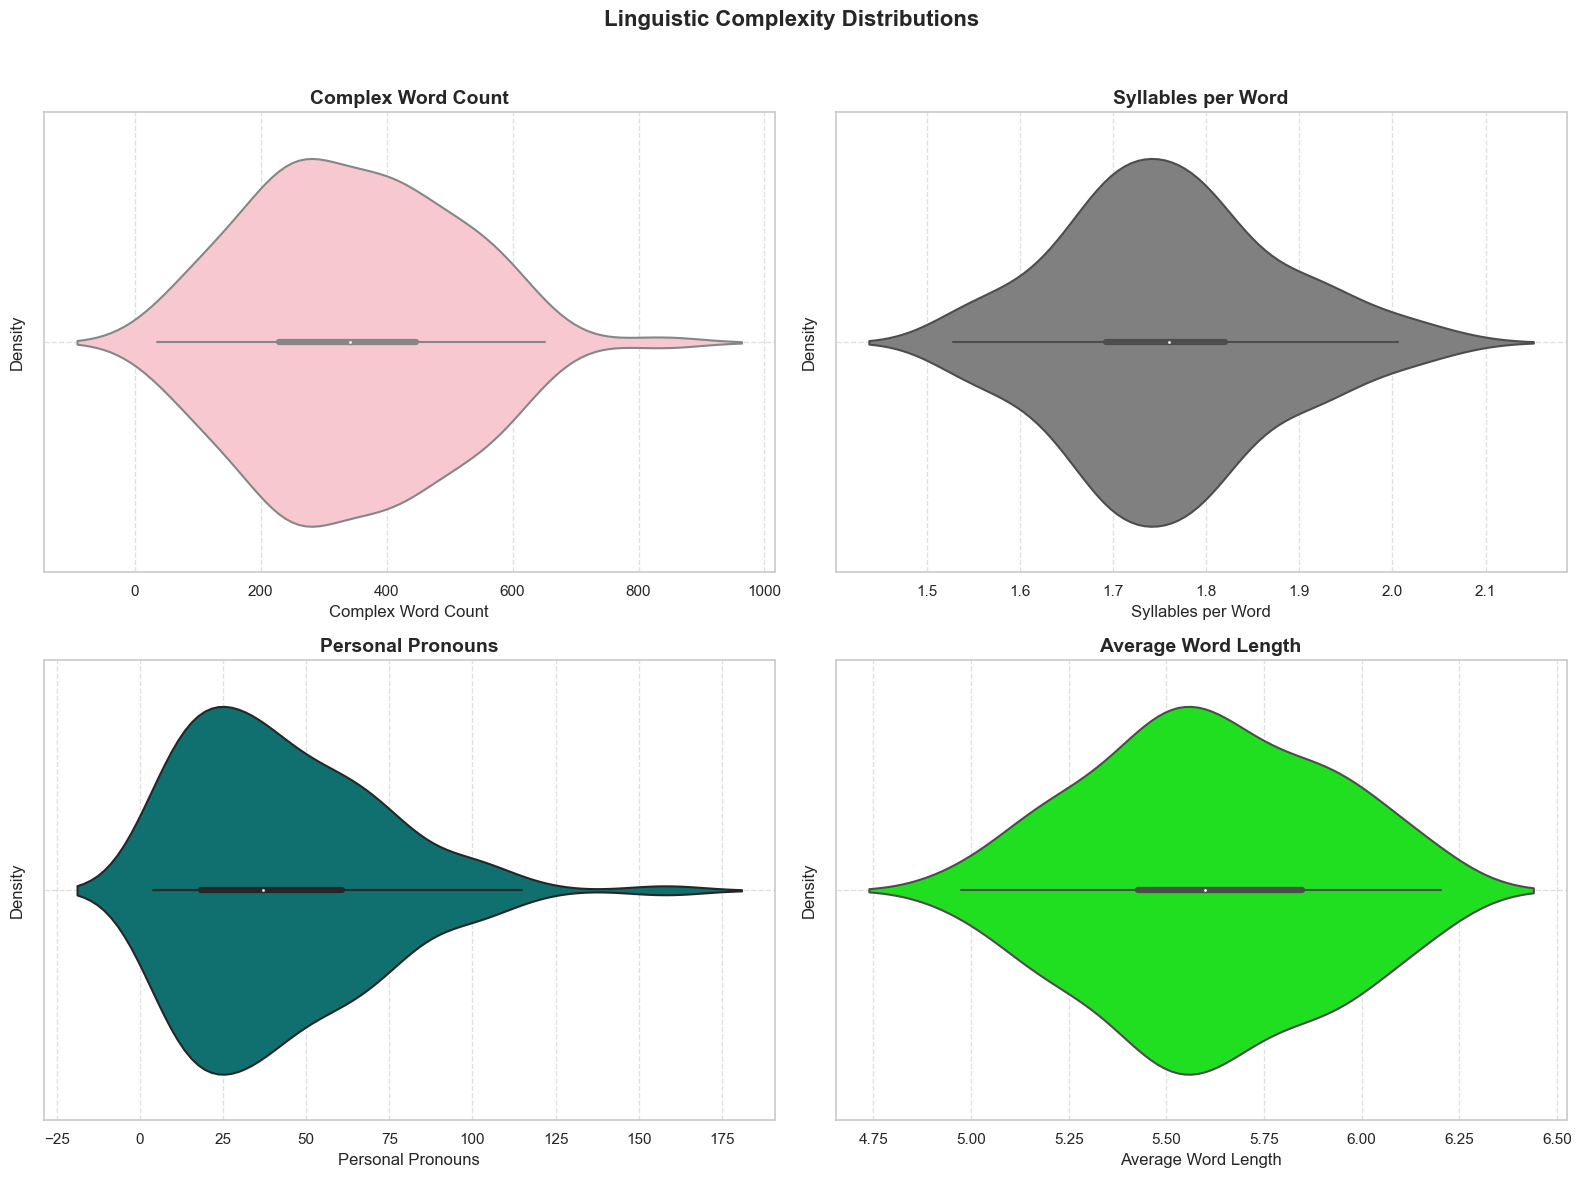

In [22]:
# Analyzing sentence structure and word difficulty
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Complex Word Count plot with enhancements using Violin plot
sns.violinplot(data=df1, x='Complex Word Count', color='pink', ax=axes[0, 0])
axes[0, 0].set_title('Complex Word Count', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Complex Word Count', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# Syllables per Word plot with enhancements using Violin plot
sns.violinplot(data=df1, x='Syllables per Word', color='gray', ax=axes[0, 1])
axes[0, 1].set_title('Syllables per Word', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Syllables per Word', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# Personal Pronouns plot with enhancements using Violin plot
sns.violinplot(data=df1, x='Personal Pronouns', color='teal', ax=axes[1, 0])
axes[1, 0].set_title('Personal Pronouns', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Personal Pronouns', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].grid(True, linestyle='--', alpha=0.6)

# Average Word Length plot with enhancements using Violin plot
sns.violinplot(data=df1, x='Avg Word Length', color='lime', ax=axes[1, 1])
axes[1, 1].set_title('Average Word Length', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Word Length', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)
axes[1, 1].grid(True, linestyle='--', alpha=0.6)

# Title for the whole figure
plt.suptitle('Linguistic Complexity Distributions', fontsize=16, fontweight='bold')

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

- **Complex Word Count:** Most responses have few complex words (below 400).
- **Syllables per Word:** Most words have around 1.6-1.8 syllables.
- **Personal Pronouns:** Most responses use few personal pronouns (below 25).
- **Average Word Length:** Average word length is typically 5-6 letters.
- **Overall:** The text generally uses fewer complex words, shorter words (in terms of syllables and letters), and fewer personal pronouns, suggesting relatively low linguistic complexity on average. 

#### Step 6: Determine Sentiment Based on Positive, Negative, and Polarity Scores

In [23]:
# Define a function to determine sentiment based on scores
def determine_sentiment(row):
    if row['Positive Score'] > row['Negative Score']:
        return 'positive'
    elif row['Negative Score'] > row['Positive Score']:
        return 'negative'
    else:
        # If positive score equals negative score, use polarity for tie-breaking
        if row['Polarity Score'] > 0:
            return 'positive'
        elif row['Polarity Score'] < 0:
            return 'negative'
        else:
            return 'neutral'

# Add a new column 'Sentiment' to the DataFrame
df1['Sentiment'] = df1.apply(determine_sentiment, axis=1)

# Display the updated DataFrame with the 'Sentiment' column
df1.Sentiment

0      positive
1      positive
2      positive
3      positive
4      positive
         ...   
97     negative
98     negative
99     positive
100    positive
101    positive
Name: Sentiment, Length: 102, dtype: object

#### Check Sentiment Balance in the Data Distribution

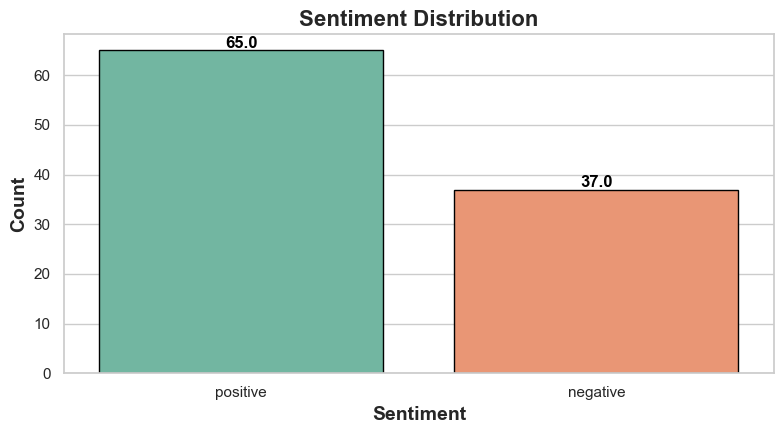

In [32]:
plt.figure(figsize=(8, 4.5))
sns.countplot(data=df1, x='Sentiment', palette='Set2', edgecolor='black')

# Adding labels and title with customized font sizes and bold text
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Sentiment Distribution', fontsize=16, fontweight='bold')

# Adding count annotations on top of the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       fontsize=12, fontweight='bold', color='black', 
                       xytext=(0, 5), textcoords='offset points')

# Display the plot
plt.tight_layout()
plt.show()

- Since the distribution between positive and negative sentiments is relatively close, the data appears to be balanced, with no significant class imbalance that would require special handling for training models.

#### Step 6.1: Encode Sentiment Labels for Model Processing

In [34]:
label_encoder = LabelEncoder()

# Fit and transform the 'Sentiment' column
df1['Sentiment'] = label_encoder.fit_transform(df1['Sentiment'])

# Display the updated DataFrame with the encoded 'Sentiment' column
df1['Sentiment']

0      1
1      1
2      1
3      1
4      1
      ..
97     0
98     0
99     1
100    1
101    1
Name: Sentiment, Length: 102, dtype: int32

#### Step 7: Clean and Preprocess Text Data for Analysis
This step involves text cleaning and preprocessing of the 'Text' column in the DataFrame df1. Various cleaning operations are applied to standardize the text and remove irrelevant information, including URLs, email addresses, phone numbers, numbers, punctuation, and stopwords. These transformations prepare the data for further text mining or analysis tasks.

In [35]:
def clean_text(df, df_column_name):
    # Replace URLs with 'webaddress'
    df[df_column_name] = df[df_column_name].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

    # Converting all messages to lowercase
    df[df_column_name] = df[df_column_name].str.lower()

    # Replace email addresses with 'email'
    df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

    # Replace money symbols with 'dollars' (£ can be typed with ALT key + 156)
    df[df_column_name] = df[df_column_name].str.replace(r'£|\$', 'dollars')

    # Replace 10-digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    df[df_column_name] = df[df_column_name].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumber')

    # Replace numbers with 'numbr'
    df[df_column_name] = df[df_column_name].str.replace(r'\d+(\.\d+)?', 'numbr')

    # Remove punctuation
    df[df_column_name] = df[df_column_name].str.replace(r'[^\w\d\s]', ' ')

    # Replace whitespace between terms with a single space
    df[df_column_name] = df[df_column_name].str.replace(r'\s+', ' ')

    # Remove leading and trailing whitespace
    df[df_column_name] = df[df_column_name].str.replace(r'^\s+|\s+?$', '')

    # Remove stopwords
    stop_words = set(stopwords.words('english') + ['u', 'ü', 'â', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
    df[df_column_name] = df[df_column_name].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

clean_text(df1, 'Text')
df1.Text

0      telemedicine use technology diagnose treat pat...
1      rise e health use electronic means facilitate ...
2      gains quality affordability accessibility way ...
3      gains quality affordability accessibility way ...
4      human race known come inventions decide future...
                             ...                        
97     jumping topic would like give overview coronav...
98     coronavirus spreads around world countries imp...
99     alibaba ping google ford companies around glob...
100    british ruled india many indians accepted work...
101    business business longer business increase bot...
Name: Text, Length: 102, dtype: object

#### Step 8: Generate Word Clouds for Positive and Negative Sentiment
In this step, Word Clouds are created to visually represent the most frequent words in the texts associated with positive and negative sentiments. The word clouds provide an intuitive way to identify the prominent terms and themes within each sentiment category. This helps in understanding the key words that contribute to positive and negative sentiments in the dataset.

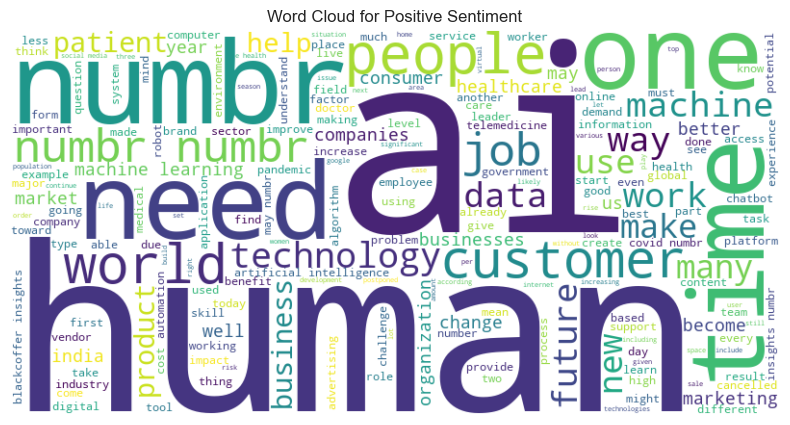

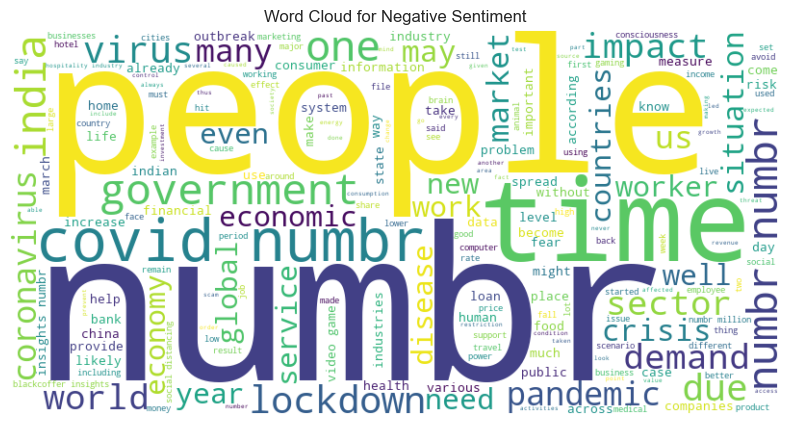

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for positive sentiment
positive_text = ' '.join(df1[df1['Sentiment'] == 1]['Text'])

# Generate a word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Plot the positive sentiment word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')
plt.show()

# Filter the DataFrame for negative sentiment
negative_text = ' '.join(df1[df1['Sentiment'] == 0]['Text'])

# Generate a word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot the negative sentiment word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')
plt.show()

In [40]:
# Save final dataset
df1.to_csv('final_text_dataset.csv',index=False)

#### Step 9: Convert Text Data into Numeric Representation Using TfidfVectorizer
In this step, we use TfidfVectorizer from sklearn to convert the textual data into a numerical format that can be used for machine learning tasks. The Term Frequency-Inverse Document Frequency (TF-IDF) method is applied to capture the importance of words in the context of the entire corpus. The vectorizer is limited to the top 3000 most frequent terms.

In [41]:
# Importing the TfidfVectorizer from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Initializing the TfidfVectorizer with a limit on the number of features
tf = TfidfVectorizer(max_features=3000)
features = tf.fit_transform(df1['Text'])
X = features
Y = df1.Sentiment

# Printing the shape of the feature matrix (X) and target vector (Y)
print(X.shape)
print(Y.shape)


(102, 3000)
(102,)


#### Step 10: Machine Learning Model Building and Evaluation
In this step, we import various machine learning algorithms and evaluate their performance for sentiment classification. The dataset is split into training and testing sets, and multiple models are trained using the training data. The models' performance will be assessed using metrics such as accuracy, precision, and confusion matrix.

In [44]:
# Importing necessary libraries for machine learning algorithms and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, classification_report, accuracy_score

# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=99, test_size=0.3)

# Printing the shapes of the training and testing datasets
print('Training feature matrix size:', X_train.shape)
print('Training target vector size:', Y_train.shape)
print('Test feature matrix size:', X_test.shape)
print('Test target vector size:', Y_test.shape)

Training feature matrix size: (71, 3000)
Training target vector size: (71,)
Test feature matrix size: (31, 3000)
Test target vector size: (31,)


#### 10.1 Logistic Regression Model Evaluation

In [45]:
# Initializing and training the Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)
y_pred = log_reg.predict(X_test)

print('\033[1m' + 'Logistic Regression Evaluation' + '\033[0m')
print('\n')
print('\033[1m' + 'Accuracy Score of Logistic Regression :' + '\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m' + 'Precision Score of Logistic Regression :' + '\033[0m', precision_score(Y_test, y_pred))
print('\n')
print('\033[1m' + 'Confusion Matrix of Logistic Regression :' + '\033[0m \n', confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m' + 'Classification Report of Logistic Regression' + '\033[0m \n', classification_report(Y_test, y_pred))

from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(log_reg, X, Y, cv=5, scoring='precision')

# Printing the cross-validation scores
print('\033[1m' + 'Cross Validation Score', log_reg, ':' + '\033[0m\n')
print("Precision CV Score:", CVscore)
print("Mean CV Precision Score:", CVscore.mean())
print("Standard Deviation:", CVscore.std())


Logistic Regression Evaluation


Accuracy Score of Logistic Regression : 0.9032258064516129


Precision Score of Logistic Regression : 0.92


Confusion Matrix of Logistic Regression : 
 [[ 5  2]
 [ 1 23]]


Classification Report of Logistic Regression 
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.92      0.96      0.94        24

    accuracy                           0.90        31
   macro avg       0.88      0.84      0.85        31
weighted avg       0.90      0.90      0.90        31

Cross Validation Score LogisticRegression() :

Precision CV Score: [0.65       0.68421053 0.8125     0.8125     0.86666667]
Mean CV Precision Score: 0.7651754385964913
Standard Deviation: 0.08318701374106076


#### 10.2 Random Forest Classifier

In [47]:
rfc=RandomForestClassifier()
rfc.fit(X_train,Y_train)
y_pred=rfc.predict(X_test)
print('\033[1m'+'Random Forest Classifier'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Random Forest Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Precision Score of Random Forest Classifier :'+'\033[0m', precision_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Random Forest Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Random Forest Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))


from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(rfc, X, Y, cv =5, scoring='precision')
print('\033[1m'+'Cross Validation Score', rfc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Precision Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Random Forest Classifier


Accuracy Score of Random Forest Classifier : 0.8709677419354839


Precision Score of Random Forest Classifier : 0.9166666666666666


Confusion matrix of Random Forest Classifier : 
 [[ 5  2]
 [ 2 22]]


classification Report of Random Forest Classifier 
               precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.92      0.92      0.92        24

    accuracy                           0.87        31
   macro avg       0.82      0.82      0.82        31
weighted avg       0.87      0.87      0.87        31

Cross Validation Score RandomForestClassifier() :

CVScore : [0.68421053 0.86666667 0.8125     0.86666667 0.76923077]
Mean CV Precision Score : 0.7998549257759784
Std deviation : 0.06840903658791457


#### 10.3 Random Forest Classifier

In [49]:
adbc=AdaBoostClassifier()
adbc.fit(X_train,Y_train)
y_pred=adbc.predict(X_test)
print('\033[1m'+'AdaBoost Classifier Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of AdaBoost Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Precision Score of Extra Trees Classifier :'+'\033[0m', precision_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of AdaBoost Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of AdaBoost Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))



from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(adbc, X, Y, cv =5, scoring='precision')
print('\033[1m'+'Cross Validation Score',adbc, ':'+'\033[0m\n')
print("Precision CVScore :" ,CVscore)
print("Mean Precision CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

AdaBoost Classifier Evaluation


Accuracy Score of AdaBoost Classifier : 0.8709677419354839


Precision Score of Extra Trees Classifier : 0.9545454545454546


Confusion matrix of AdaBoost Classifier : 
 [[ 6  1]
 [ 3 21]]


classification Report of AdaBoost Classifier 
               precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.95      0.88      0.91        24

    accuracy                           0.87        31
   macro avg       0.81      0.87      0.83        31
weighted avg       0.89      0.87      0.88        31

Cross Validation Score AdaBoostClassifier() :

Precision CVScore : [0.83333333 0.85714286 0.85714286 0.91666667 0.54545455]
Mean Precision CV Score : 0.8019480519480519
Std deviation : 0.13116954552403595


### Model Evaluation Summary

Based on the evaluation of multiple machine learning models, the performance of the Logistic Regression, Random Forest Classifier, and AdaBoost Classifier models was analyzed. Here's a summary of the key results:

1. **Logistic Regression**:
   - **Accuracy**: 90.32%
   - **Precision**: 92% for the positive class
   - Logistic Regression showed a solid performance with a balanced classification report. However, the model's cross-validation scores indicate some variability in precision across different folds (mean precision score of 76.5%).

2. **Random Forest Classifier**:
   - **Accuracy**: 87.10%
   - **Precision**: 91.67% for the positive class
   - The Random Forest Classifier demonstrated strong precision for the positive class, but its performance was slightly lower than Logistic Regression and AdaBoost in terms of overall accuracy. The cross-validation precision score has a mean of 79.99%, indicating reasonable consistency across folds.

3. **AdaBoost Classifier**:
   - **Accuracy**: 87.10%
   - **Precision**: 95.45% for the positive class
   - AdaBoost achieved a very high precision score for the positive class, showcasing its ability to correctly classify positive instances. However, the model's performance varied more during cross-validation, with a mean precision score of 80.19%.

### Conclusion:
- **Top Performers**: Logistic Regression, Random Forest Classifier, and AdaBoost Classifier all performed well, but **Logistic Regression** and **AdaBoost Classifier** stood out for their high precision, especially for identifying positive instances.
- **Improvements**: While the models performed well overall, there is room for improvement through hyperparameter tuning, particularly for the **Random Forest Classifier** and **AdaBoost Classifier** to enhance stability and precision.

The results suggest that **Logistic Regression** could be further optimized to enhance their precision and overall performance.

#### Step 11: Evaluating Logistic Regression Model Performance

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

log_reg = LogisticRegression()

# Define the parameter grid for tuning
param_grid = {
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
    'solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [100, 200, 300]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, Y_train)

# Get best parameters
best_params = grid_search.best_params_
print("\n\033[1mBest Parameters found:\033[0m", best_params)


Best Parameters found: {'C': 1.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [109]:
final_params = {
        'C': 10,
        'solver': 'saga',
        'penalty': 'l2',
        'max_iter': 4 }

# Create the model with chosen parameters
final_model = LogisticRegression(
    C=final_params['C'],
    solver=final_params['solver'],
    penalty=final_params['penalty'],
    max_iter=final_params['max_iter'],
    random_state=99
)

final_model.fit(X_train, Y_train)
y_pred = final_model.predict(X_test)

# Evaluation
print('\n\033[1mAfter HPT Logistic Regression Evaluation\033[0m\n')
print('\033[1mAccuracy Score:\033[0m', accuracy_score(Y_test, y_pred))
print('\033[1mPrecision Score:\033[0m', precision_score(Y_test, y_pred))
print('\033[1mConfusion Matrix:\033[0m\n', confusion_matrix(Y_test, y_pred))
print('\033[1mClassification Report:\033[0m\n', classification_report(Y_test, y_pred))



After HPT Logistic Regression Evaluation

Accuracy Score: 0.9032258064516129
Precision Score: 0.92
Confusion Matrix:
 [[ 5  2]
 [ 1 23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.92      0.96      0.94        24

    accuracy                           0.90        31
   macro avg       0.88      0.84      0.85        31
weighted avg       0.90      0.90      0.90        31



After hyperparameter tuning, the Logistic Regression model showed **no change in accuracy (90.32%)** and **precision (0.92)** compared to the initial model. Indicating that the initial model was already well-optimized. Hyperparameter tuning **maintained performance** rather than improving it.  

You can **further try different parameter combinations** and **enhance the parameter range in `GridSearchCV`** to explore more possibilities for performance improvement.

In [111]:
# Saving the Model

import pickle
with open('Sentiment_Analysis.pkl', 'wb') as model_file:
    pickle.dump(final_model, model_file)

#### Step 12: Loading the Trained Model and Making Final Predictions

In [112]:
# Load the saved AdaBoost model
with open('Sentiment_Analysis.pkl', 'rb') as model_file:
    Sentiment_Analysis = pickle.load(model_file)

# Predict the labels on test data
predicted_labels = Sentiment_Analysis.predict(X_test)

# Map numeric predicted labels to sentiment strings
sentiment_labels = ['negative' if label == 0 else 'positive' for label in predicted_labels]

# Create final DataFrame with actual labels, predicted numeric labels, and predicted sentiments
final_df = pd.DataFrame({
    'Actual Label': Y_test,
    'Predicted Label': predicted_labels,
    'Predicted Sentiment': sentiment_labels
})

# Display the final DataFrame
final_df.head()


,Actual Label,Predicted Label,Predicted Sentiment
51,1,1,positive
38,1,1,positive
14,1,1,positive
36,1,1,positive
97,0,0,negative


### 📝 **Final Summary**

This is a **demo model** designed to showcase one of the approaches we can use for **sentiment analysis**. In this example, we applied machine learning techniques on a **sample/demo dataset** to classify text data into **positive** and **negative** sentiments.

We demonstrated the complete workflow, including:

- Data preprocessing  
- Model training using AdaBoost  
- Evaluation of performance metrics  
- Hyperparameter tuning (for Logistic Regression)  
- And finally, saving and loading the model for prediction

The final predictions were mapped to sentiment labels for easy interpretation and combined with actual values into a structured DataFrame for comparison.

> This project serves as a foundational framework and can be **extended to real-world datasets** with more sophisticated preprocessing, richer feature engineering (e.g., TF-IDF, word embeddings), and advanced models like BERT or LSTM.

Feel free to enhance it further with more complex models and a larger dataset! 😊